# Regression - Prediciting Life Expectancy for US

### Now it is time to use other models to reduce the complexity of our baseline model by using several feature selection techniques. The aim here is to reduce the amount of features for our 'client', there will no doubt be some tradeoff between model accuracy and complexity.

As we can see above, we get a R2 scores of 83% for a single train-test split model and 88% if we conduct a cross-validation with 5 splits. This however might result in a model that is too complex noting the number of features we have. Let's conduct two different ways of selecting only the best features:
- filter methods
    - low variance
    - Pearson's Correlation (Given majority of our features are continuous)
- wrapper methods
    - Recurvsive Feature Elimination
    - Stepwise Selection
- embedded methods 
    - Lasso

In [1]:
import pandas as pd
import numpy as np
from functions import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

In [2]:
df_clean = pd.read_csv('clean_data.csv', index_col=[0])

In [3]:
to_drop = ['State_Abbreviation', 'Name', 'Life_expectancy_raw_value']
X = df_clean.drop(to_drop, axis = 1)
y = df_clean['Life_expectancy_raw_value']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [80]:
all_model_summary_df = pd.DataFrame([], columns = ['model', 'R2_test', 'AIC', 'n_features', '>0.05_pvalues'])
all_model_summary_df['model'] = ['Baseline', 'Basic - Top Correlation',
                                 'Filter', 
                                 'Wrappper - RFE', 'Wrappper - Stepwise',
                                 'Embedded - Lasso',
                                ]

### 1. Baseline model - All available features

In [81]:
baseline_test_r2 = statsmodel_regression(X_train, add_constant(X_test), y_train, y_test)[0]
baseline_estimator = statsmodel_regression(X_train, add_constant(X_test), y_train, y_test)[1]

In [84]:
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'n_features'] = len(baseline_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'AIC'] = baseline_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'R2_test'] = baseline_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', '>0.05_pvalues'] = sum(baseline_estimator.pvalues > 0.05)

In [85]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.83,6143.64,77,48
1,Basic - Top Correlation,NaN,NaN,NaN,NaN
2,Filter,NaN,NaN,NaN,NaN
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 2. Basic - Features with Highest Correlation with Target

In [127]:
initial_matrix = abs(df_clean.corr().Life_expectancy_raw_value)

target_correlation_threshold = 0.5

final = list(initial_matrix[(initial_matrix.sort_values(ascending=False) > target_correlation_threshold)].index)
final.remove('Life_expectancy_raw_value')
final

['Premature_death_raw_value',
 'Poor_or_fair_health_raw_value',
 'Poor_physical_health_days_raw_value',
 'Poor_mental_health_days_raw_value',
 'Adult_smoking_raw_value',
 'Adult_obesity_raw_value',
 'Physical_inactivity_raw_value',
 'Excessive_drinking_raw_value',
 'Teen_births_raw_value',
 'Some_college_raw_value',
 'Children_in_poverty_raw_value',
 'Injury_deaths_raw_value',
 'Premature_age-adjusted_mortality_raw_value',
 'Frequent_physical_distress_raw_value',
 'Frequent_mental_distress_raw_value',
 'Diabetes_prevalence_raw_value',
 'Food_insecurity_raw_value',
 'Motor_vehicle_crash_deaths_raw_value',
 'Insufficient_sleep_raw_value',
 'Median_household_income_raw_value',
 'Children_eligible_for_free_or_reduced_price_lunch_raw_value']

In [128]:
basic_test_r2 = statsmodel_regression(X_train[final], add_constant(X_test[final]), y_train, y_test)[0]
basic_estimator = statsmodel_regression(X_train[final], add_constant(X_test[final]), y_train, y_test)[1]

In [129]:
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'n_features'] = len(basic_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'AIC'] = basic_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'R2_test'] = basic_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', '>0.05_pvalues'] = sum(basic_estimator.pvalues > 0.05)

In [130]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.83,6143.64,77,48
1,Basic - Top Correlation,0.82,6644.27,22,6
2,Filter,0.77,7211.08,30,13
3,Wrappper - RFE,0.84,6169.38,67,39
4,Wrappper - Stepwise,0.83,6193.23,25,0
5,Embedded - Lasso,0.69,7959.28,8,3


### 3. Filter Method - drop features with no or low variance & high correlation with other features

In [86]:
from sklearn.feature_selection import VarianceThreshold

variance_threshold = 0.025

constant_filter = VarianceThreshold(threshold = variance_threshold)
constant_filter.fit(X_train)

VarianceThreshold(threshold=0.025)

In [87]:
included_cols = X_train.columns[constant_filter.get_support()]
High_Var_Features = X_train[included_cols]

In [88]:
corr_matrix = High_Var_Features.corr()
correlated_features = set()

corr_threshold = 0.7

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)
    
High_Var_Features_low_corr = High_Var_Features.drop(list(correlated_features), axis = 1)

In [89]:
X_test_1 = add_constant(X_test[High_Var_Features_low_corr.columns])

In [90]:
filter_test_r2 = statsmodel_regression(High_Var_Features_low_corr, X_test_1, y_train, y_test)[0]
filter_estimator = statsmodel_regression(High_Var_Features_low_corr, X_test_1, y_train, y_test)[1]

In [91]:
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'n_features'] = len(filter_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'AIC'] = filter_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'R2_test'] = filter_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', '>0.05_pvalues'] = sum(filter_estimator.pvalues > 0.05)

In [92]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.83,6143.64,77,48
1,Basic - Top Correlation,NaN,NaN,NaN,NaN
2,Filter,0.77,7211.08,30,13
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 4. Wrapper - Recursive Feature Elimination

In [93]:
from sklearn.feature_selection import RFECV, RFE

In [94]:
linreg = LinearRegression()
rfecv = RFECV(linreg, step = 1, scoring='r2', cv=10)
rfecv.fit(X_train, y_train)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

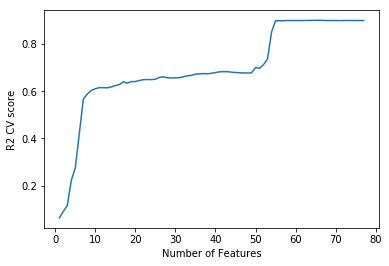

In [95]:
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of Features')
plt.ylabel('R2 CV score')
plt.show()

In [96]:
to_include = X_train.columns[rfecv.get_support()]

In [97]:
RFE_test_r2 = statsmodel_regression(X_train[to_include], add_constant(X_test[to_include]), y_train, y_test)[0]
RFE_estimator = statsmodel_regression(X_train[to_include], add_constant(X_test[to_include]), y_train, y_test)[1]

In [98]:
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'n_features'] = len(RFE_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'AIC'] = RFE_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'R2_test'] = RFE_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', '>0.05_pvalues'] = sum(RFE_estimator.pvalues > 0.05)

In [99]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.83,6143.64,77,48
1,Basic - Top Correlation,NaN,NaN,NaN,NaN
2,Filter,0.77,7211.08,30,13
3,Wrappper - RFE,0.84,6169.38,67,39
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 5. Stepwise Selection - Combination of Forward and Backward feature selection

In [100]:
stepwise_columns = stepwise_selection(X_train, y_train, threshold_in = 0.01, verbose=True)

Add  Frequent_mental_distress_raw_value with p-value 0.0
Add  Premature_age-adjusted_mortality_raw_value with p-value 0.0
Add  Release_Year                   with p-value 0.0
Add  Driving_alone_to_work_raw_value with p-value 6.65083e-41
Add  Poor_or_fair_health_raw_value  with p-value 3.13978e-19
Add  %_below_18_years_of_age_raw_value with p-value 2.8992e-16
Add  Air_pollution_-_particulate_matter_raw_value with p-value 1.51839e-12
Add  %_Asian_raw_value              with p-value 1.57187e-17
Add  Child_mortality_raw_value      with p-value 2.31754e-09
Add  Limited_access_to_healthy_foods_raw_value with p-value 6.40207e-09
Add  Severe_housing_problems_raw_value with p-value 1.38944e-05
Add  %_Non-Hispanic_white_raw_value with p-value 2.51868e-06
Add  Low_birthweight_raw_value      with p-value 0.000236109
Add  Income_inequality_raw_value    with p-value 0.00033586
Add  %_Native_Hawaiian/Other_Pacific_Islander_raw_value with p-value 0.000505954
Add  Primary_care_physicians_raw_value with

In [101]:
stepwise_test_r2 = statsmodel_regression(X_train[stepwise_columns], X_test[stepwise_columns], y_train, y_test)[0]
stepwise_estimator = statsmodel_regression(X_train[stepwise_columns], X_test[stepwise_columns], y_train, y_test)[1]

In [102]:
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'n_features'] = len(stepwise_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'AIC'] = stepwise_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'R2_test'] = stepwise_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', '>0.05_pvalues'] = sum(stepwise_estimator.pvalues > 0.05)

In [103]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.83,6143.64,77,48
1,Basic - Top Correlation,NaN,NaN,NaN,NaN
2,Filter,0.77,7211.08,30,13
3,Wrappper - RFE,0.84,6169.38,67,39
4,Wrappper - Stepwise,0.83,6193.23,25,0
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 6. Embedded - Lasso L2 Regression

In [104]:
from sklearn.linear_model import Lasso

lasso = Lasso(0.25).fit(X_train, y_train)
lasso_column = X_train.columns[lasso.coef_ > 0]

In [105]:
lasso_test_r2 = statsmodel_regression(X_train[lasso_column], add_constant(X_test[lasso_column]), y_train, y_test)[0]
lasso_estimator = statsmodel_regression(X_train[lasso_column], add_constant(X_test[lasso_column]), y_train, y_test)[1]

In [106]:
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'n_features'] = len(lasso_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'AIC'] = lasso_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'R2_test'] = lasso_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', '>0.05_pvalues'] = sum(lasso_estimator.pvalues > 0.05)

In [107]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.83,6143.64,77,48
1,Basic - Top Correlation,NaN,NaN,NaN,NaN
2,Filter,0.77,7211.08,30,13
3,Wrappper - RFE,0.84,6169.38,67,39
4,Wrappper - Stepwise,0.83,6193.23,25,0
5,Embedded - Lasso,0.69,7959.28,8,3
